---
## **Thư viện**
---

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt 
import seaborn as sns 
import copy
import matplotlib.pyplot as plt 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from mpl_toolkits.mplot3d import Axes3D

---
## **Đọc dữ liệu**
---

In [2]:
df=pd.read_excel("C:\\Users\\PC\\Downloads\\Nhom10\\ML_AFFINITY PROPAGATION_NHOM10_PIZZAHUT DATASET.xlsx")
df

,BillID,Channel,OrderFrom,TransactionDate,SalesAmount,CustomerID,CustomerGender,VoucherStatus,Province
0,925181,Delivery,CALL CENTER,2022-11-07,376676,1599602,Female,No,Ho Chi Minh City
1,875964,Take Away,WEBSITE,2022-10-13,109927,1761308,Unknown,No,Ho Chi Minh City
2,1021982,Delivery,WEBSITE,2022-12-29,2313260,1692638,Unknown,No,Ho Chi Minh City
3,1007513,Delivery,CALL CENTER,2022-12-22,1871407,1605462,Male,No,Ho Chi Minh City
4,1015400,Dine In,STORE,2022-12-25,689747,70040,Female,No,Ho Chi Minh City
...,...,...,...,...,...,...,...,...,...
1495,859105,Take Away,STORE,2022-10-03,89538,676327,Unknown,No,Ho Chi Minh City
1496,925602,Take Away,APP,2022-11-07,156713,1667719,Female,No,Ho Chi Minh City
1497,917288,Delivery,CALL CENTER,2022-11-03,405818,551659,Unknown,No,Ho Chi Minh City
1498,980535,Delivery,WEBSITE,2022-12-08,303575,920724,Unknown,No,Ho Chi Minh City


---
## **Tiền xử lý dữ liệu**
---

### **EDA**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BillID           1500 non-null   int64         
 1   Channel          1500 non-null   object        
 2   OrderFrom        1500 non-null   object        
 3   TransactionDate  1500 non-null   datetime64[ns]
 4   SalesAmount      1500 non-null   int64         
 5   CustomerID       1500 non-null   int64         
 6   CustomerGender   1500 non-null   object        
 7   VoucherStatus    1500 non-null   object        
 8   Province         1500 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 105.6+ KB


In [4]:
df.describe()

,BillID,TransactionDate,SalesAmount,CustomerID
count,1.500000e+03,1500,1.500000e+03,1.500000e+03
mean,9.421668e+05,2022-11-16 09:46:33.600000256,3.444380e+05,1.061367e+06
min,8.529200e+05,2022-10-01 00:00:00,2.094900e+04,1.120000e+02
25%,8.980422e+05,2022-10-23 00:00:00,1.952278e+05,5.149332e+05
50%,9.437440e+05,2022-11-18 00:00:00,2.897025e+05,1.049294e+06
75%,9.872235e+05,2022-12-11 00:00:00,4.042420e+05,1.600427e+06
max,1.028975e+06,2022-12-31 00:00:00,6.022211e+06,2.173664e+06
std,5.165086e+04,NaN,3.263135e+05,6.271797e+05


### **Tính giá trị RFM của mỗi khách hàng**

In [5]:
df = df.loc[:, ['CustomerID', 'SalesAmount', 'TransactionDate']]
# Lấy ngày giao dịch cuối cùng của từng khách hàng
df['Last Order'] = df.groupby('CustomerID')['TransactionDate'].transform('max')
# Chuyển đổi định dạng ngày
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Last Order'] = pd.to_datetime(df['Last Order'])
# Tạo ngày phân tích cố định
df['Report Date'] = '2023-1-1'
df['Report Date'] = pd.to_datetime(df['Report Date'])
# Tính recency (khoảng thời gian từ lần mua cuối đến ngày báo cáo)
df['Recency'] = (df['Report Date'] - df['Last Order']).dt.days
# Tính frequency (số lần giao dịch của từng khách hàng)
df['Frequency'] = df.groupby('CustomerID')['TransactionDate'].transform('count')
# Tính tổng GMV cho từng khách hàng
df['Monetary'] = df.groupby('CustomerID')['SalesAmount'].transform('sum')

In [6]:
df_new = df.loc[:, ['CustomerID', 'Recency', 'Frequency', 'Monetary']]
df_new.drop_duplicates(inplace=True)
df_new.reset_index()
df_new

,CustomerID,Recency,Frequency,Monetary
0,1599602,55,1,376676
1,1761308,80,1,109927
2,1692638,3,1,2313260
3,1605462,10,1,1871407
4,70040,7,1,689747
...,...,...,...,...
1495,676327,90,1,89538
1496,1667719,55,1,156713
1497,551659,59,1,405818
1498,920724,24,1,303575


In [7]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1477 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CustomerID  1477 non-null   int64
 1   Recency     1477 non-null   int64
 2   Frequency   1477 non-null   int64
 3   Monetary    1477 non-null   int64
dtypes: int64(4)
memory usage: 57.7 KB


In [8]:
df_new.describe()

,CustomerID,Recency,Frequency,Monetary
count,1.477000e+03,1477.000000,1477.000000,1.477000e+03
mean,1.063928e+06,45.345972,1.015572,3.498017e+05
std,6.268409e+05,27.459556,0.129209,3.294608e+05
min,1.120000e+02,1.000000,1.000000,2.094900e+04
25%,5.186930e+05,21.000000,1.000000,2.011600e+05
50%,1.057924e+06,44.000000,1.000000,2.922320e+05
75%,1.600998e+06,70.000000,1.000000,4.084290e+05
max,2.173664e+06,92.000000,3.000000,6.022211e+06


### **Vẽ biểu đồ trực quan các cột RFM**

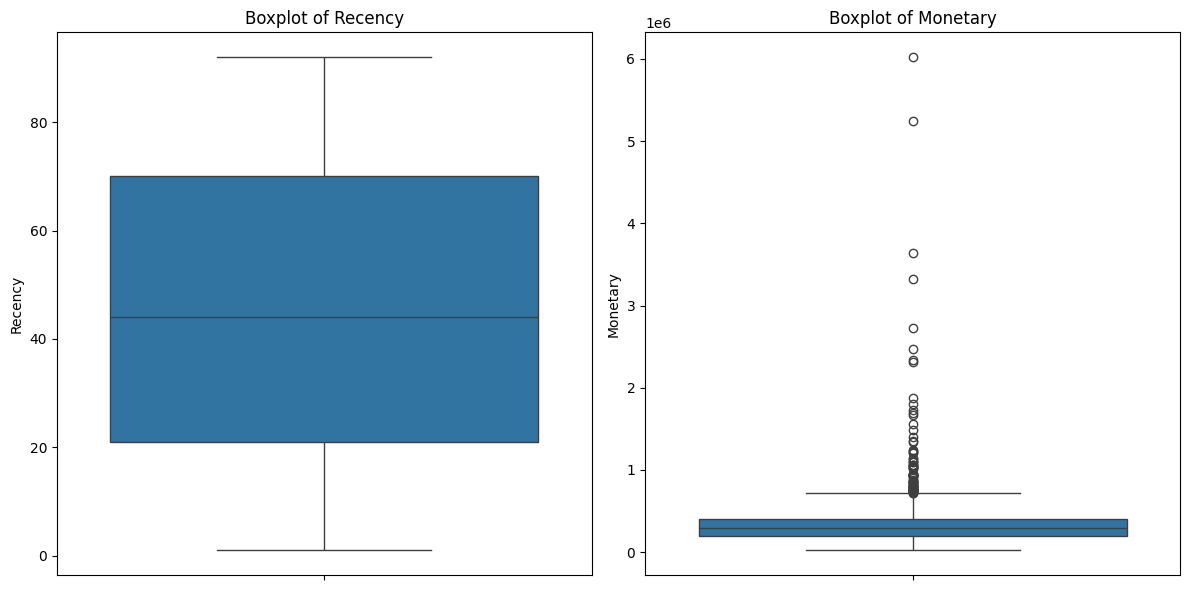

In [9]:
# Vẽ boxplot cho Recency và Monetary
plt.figure(figsize=(12, 6))
# Boxplot Recency
plt.subplot(1, 2, 1)
sns.boxplot(y=df_new['Recency'])
plt.title('Boxplot of Recency')
plt.ylabel('Recency')
# Boxplot Monetary
plt.subplot(1, 2, 2)
sns.boxplot(y=df_new['Monetary'])
plt.title('Boxplot of Monetary')
plt.ylabel('Monetary')
plt.tight_layout()
plt.show()

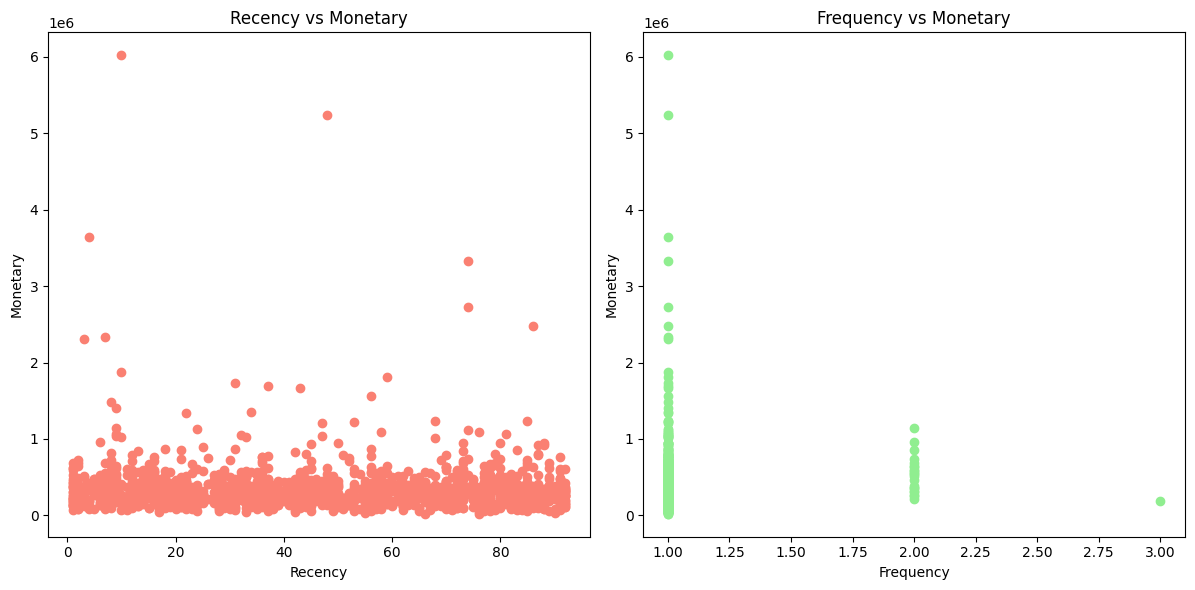

In [10]:
# Thiết lập kích thước toàn bộ figure
plt.figure(figsize=(18, 6))
# Scatter plot: Recency vs Monetary
plt.subplot(1, 3, 1)
plt.scatter(df_new['Recency'], df_new['Monetary'], color='salmon')
plt.title('Recency vs Monetary')
plt.xlabel('Recency')
plt.ylabel('Monetary')
# Scatter plot: Frequency vs Monetary
plt.subplot(1, 3, 2)
plt.scatter(df_new['Frequency'], df_new['Monetary'], color='lightgreen')
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.tight_layout()
plt.show()

### **Chuẩn hóa dữ liệu**

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_new.iloc[:, 1:])
scaled_features

array([[ 0.3516917 , -0.12055938,  0.08159828],
       [ 1.26242992, -0.12055938, -0.7283291 ],
       [-1.54264378, -0.12055938,  5.96162938],
       ...,
       [ 0.49740982, -0.12055938,  0.17008185],
       [-0.77762368, -0.12055938, -0.14035757],
       [-1.43335519, -0.12055938, -0.14297789]])

---
## **Áp dụng thuật toán Affinity Propagation**
---

### **Tìm giá trị preference để silhouette score cao nhất**

In [12]:
def plot_silhouette_scores(preference_values, silhouette_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(preference_values, silhouette_scores, marker='o', linestyle='-', color='b', label='Silhouette Score')
    plt.xlabel('Preference Values')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Preference Values')
    plt.legend()
    plt.grid()
    plt.show()

### **Hàm tìm giá trị preference tốt nhất**

In [13]:
def find_best_preference(scaled_features):
    # Tính ma trận tương đồng (cosine similarity)
    similarity_matrix = cosine_similarity(scaled_features)
    # Tập giá trị preference cần kiểm tra
    preference_values = np.linspace(-250, -10, 20) 
    # Biến lưu kết quả tốt nhất
    best_score = -1
    best_preference = None
    best_clusters = None
    best_cluster_centers = None
    preference_list = []
    silhouette_score_list = []
    # Lặp qua các giá trị preference
    for preference in preference_values:
        # Khởi tạo Affinity Propagation
        ap = AffinityPropagation(preference= preference, affinity='precomputed', damping=0.9, random_state=42)
        ap.fit(similarity_matrix)
        # Kiểm tra số cụm hợp lệ
        if len(set(ap.labels_)) > 1 and len(set(ap.labels_)) < 100:
            # Tính Silhouette Score
            score = silhouette_score(scaled_features, ap.labels_)
            preference_list.append(preference)  # Lưu preference
            silhouette_score_list.append(score)  # Lưu Silhouette Score
            #print(f"Preference: {preference}, Silhouette Score: {score}, Number of Clusters: {len(set(ap.labels_))}")
            # Cập nhật giá trị tốt nhất nếu điểm cao hơn
            if score > best_score:
                best_score = score
                best_preference = preference
                best_clusters = ap.labels_
                best_cluster_centers = ap.cluster_centers_indices_

    # Kết quả cuối cùng
    return best_preference, best_score, best_clusters, best_cluster_centers, preference_list, silhouette_score_list

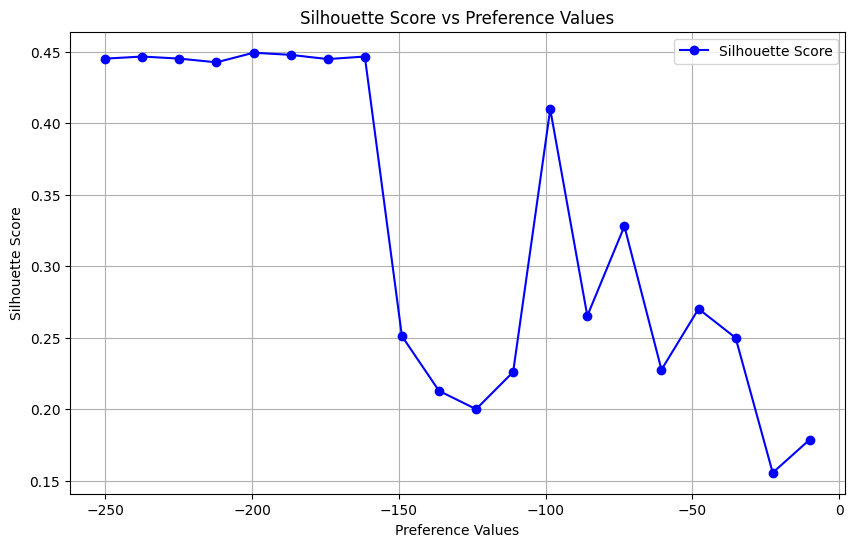

Best Preference: -199.4736842105263, Best Silhouette Score: 0.44930826191355383
Optimal Clusters: [2 2 1 ... 2 0 0]
Cluster Centers: [  38   39 1155]
Number of Clusters: 3


In [14]:
best_preference, best_score, best_clusters, best_cluster_centers, preference_list, silhouette_score_list = find_best_preference(scaled_features)
plot_silhouette_scores(preference_list, silhouette_score_list)
# In cụm tối ưu
print(f"Best Preference: {best_preference}, Best Silhouette Score: {best_score}")
print(f"Optimal Clusters: {best_clusters}")
print(f"Cluster Centers: {best_cluster_centers}")
print(f"Number of Clusters: {len(set(best_clusters))}")

In [15]:
best_clusters

array([2, 2, 1, ..., 2, 0, 0], dtype=int64)

### **Gán cụm cho từng khách hàng**

In [16]:
df_new['Cluster'] = best_clusters + 1
df_new

,CustomerID,Recency,Frequency,Monetary,Cluster
0,1599602,55,1,376676,3
1,1761308,80,1,109927,3
2,1692638,3,1,2313260,2
3,1605462,10,1,1871407,2
4,70040,7,1,689747,1
...,...,...,...,...,...
1495,676327,90,1,89538,3
1496,1667719,55,1,156713,3
1497,551659,59,1,405818,3
1498,920724,24,1,303575,1


## **Trực quan các cụm**

C:\Users\PC\AppData\Local\Temp\ipykernel_24476\2232711917.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(recency, frequency, monetary, label=f'Cluster {cluster_label + 1}', cmap='viridis')


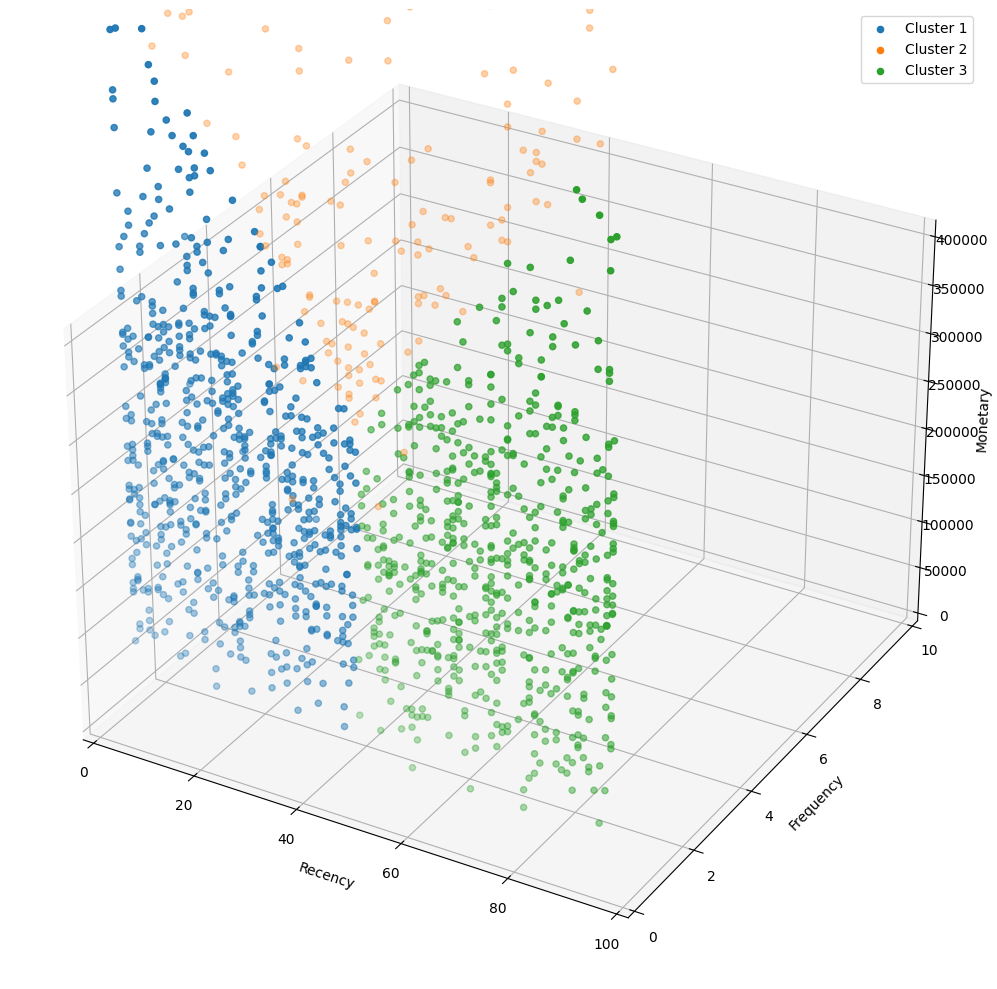

In [17]:
# Tạo biểu đồ 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# Lấy các giá trị Recency, Frequency và Monetary cho từng cụm
for cluster_label in np.unique(best_clusters):  # Duyệt qua các cụm
    cluster_data = df_new[best_clusters == cluster_label]
    recency = cluster_data['Recency']
    frequency = cluster_data['Frequency']
    monetary = cluster_data['Monetary']
    ax.scatter(recency, frequency, monetary, label=f'Cluster {cluster_label + 1}', cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_xlim([0, 100])
ax.set_ylim([0, 10])
ax.set_zlim([0,4.084290e+05])  
ax.legend()
plt.tight_layout()
plt.show()

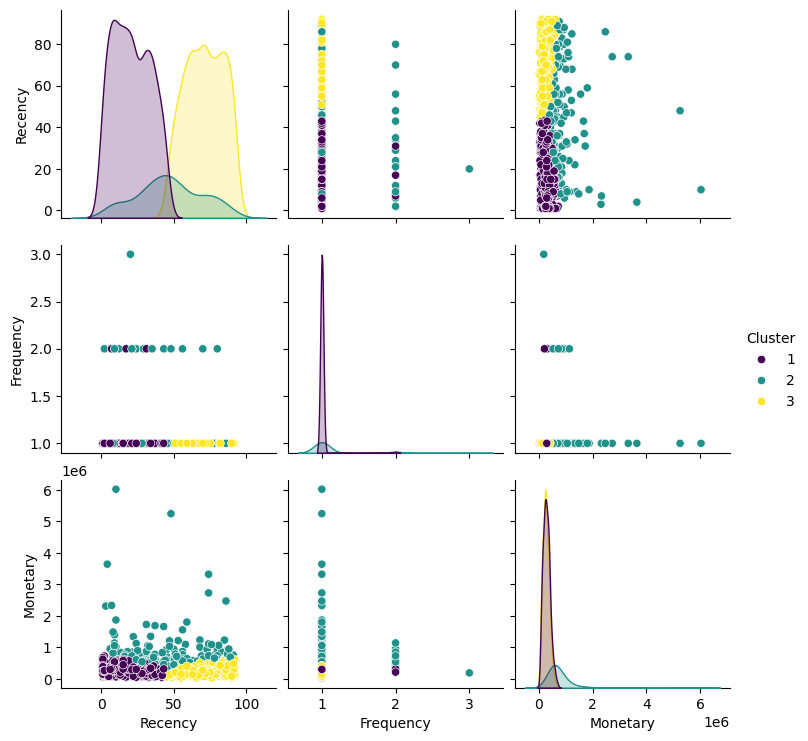

In [18]:
sns.pairplot(
    df_new,
    vars=['Recency', 'Frequency', 'Monetary'],  
    hue= 'Cluster',
    palette='viridis',
    diag_kind='kde',
    markers='o'
)
plt.show()